<a href="https://colab.research.google.com/github/Tierprot/Deep-Learning/blob/master/hw_4_multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import itertools
import numpy as np
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

%matplotlib inline

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!ls /content/gdrive/'My Drive'/Colab_Notebooks/22.01.20/utils.py

import sys
sys.path.append('/content/gdrive/My Drive/Colab_Notebooks')
from utils import mnist, plot_graphs, plot_mnist, mnist_transform

'/content/gdrive/My Drive/Colab_Notebooks/22.01.20/utils.py'


In [3]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train_loader, test_loader = mnist(batch_size=200, valid=0, transform=mnist_transform)



Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw
Processing...
Done!


In [0]:
class Encoder_multi(nn.Module):
    def __init__(self, latent_size=10):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 32)
        self.fc2 = nn.Linear(32,latent_size)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x
    
class Decoder_multi(nn.Module):
    def __init__(self, latent_size=10):
        super().__init__()
        self.fc1 = nn.Linear(latent_size, 32)
        self.fc2 = nn.Linear(32, 28*28)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x

class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder_multi(latent_size)
        self.D = Decoder_multi(latent_size)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [0]:
models = {'2': Net(latent_size=2), '32': Net(latent_size=32)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [0]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):        
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 150 == 0:
            line = 'Train Epoch: {} [{:05d}/{}] '.format(
                epoch, batch_idx * len(data), train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{:05d}/{}] '.format(
            epoch, batch_idx * len(data), train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append(models[k]._loss)
        print(line + losses)

def test(models, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:            
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append(test_loss[k])
    
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
line = lambda i, l: '{}: '.format(i) + avg_lambda(l)

In [0]:
for epoch in range(1, 100):
    for model in models.values():
        model.train()
    train(epoch, models, log=train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, log=test_log)

Train Epoch: 1 [00000/60000] 2: 0.987783 32: 0.953947
Train Epoch: 1 [30000/60000] 2: 0.723883 32: 0.600330
Train Epoch: 1 [60000/60000] 2: 0.530981 32: 0.355962
Test set:
2: loss: 0.5291
32: loss: 0.3567

Train Epoch: 2 [00000/60000] 2: 0.523134 32: 0.347514
Train Epoch: 2 [30000/60000] 2: 0.398697 32: 0.301647
Train Epoch: 2 [60000/60000] 2: 0.338492 32: 0.284848
Test set:
2: loss: 0.3394
32: loss: 0.2860

Train Epoch: 3 [00000/60000] 2: 0.330602 32: 0.276040
Train Epoch: 3 [30000/60000] 2: 0.310650 32: 0.280209
Train Epoch: 3 [60000/60000] 2: 0.295052 32: 0.275363
Test set:
2: loss: 0.2965
32: loss: 0.2765

Train Epoch: 4 [00000/60000] 2: 0.286747 32: 0.266411
Train Epoch: 4 [30000/60000] 2: 0.287960 32: 0.275292
Train Epoch: 4 [60000/60000] 2: 0.281670 32: 0.272190
Test set:
2: loss: 0.2831
32: loss: 0.2732

Train Epoch: 5 [00000/60000] 2: 0.273078 32: 0.263132
Train Epoch: 5 [30000/60000] 2: 0.279797 32: 0.271658
Train Epoch: 5 [60000/60000] 2: 0.276179 32: 0.268088
Test set:
2: l

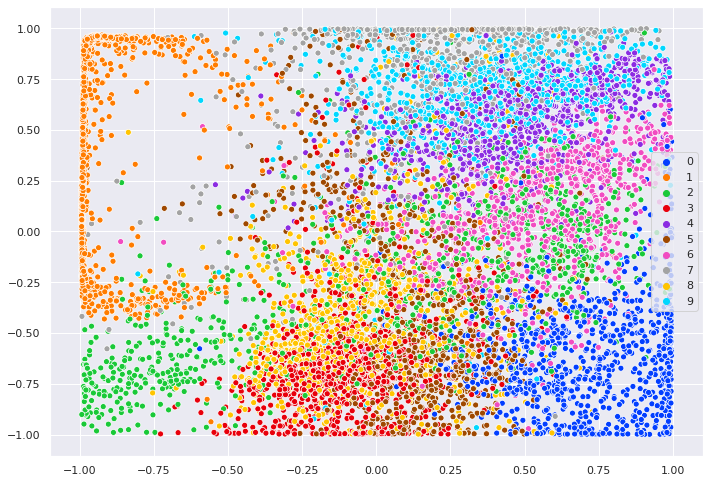

In [0]:
#результат преобразования данных 2х нейронным кодировщиком

from sklearn.manifold import TSNE
import seaborn as sns
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

data,labels = next(iter(DataLoader(dataset=datasets.MNIST(root='./MNIST_data', train=False, download=True, transform=mnist_transform), batch_size=10000, shuffle=True)))

data = models['2'].E(data.view(-1, 28*28))
data = data.detach().numpy()
sns.scatterplot(data[:,0], data[:,1], hue=labels, legend='full', palette=palette)

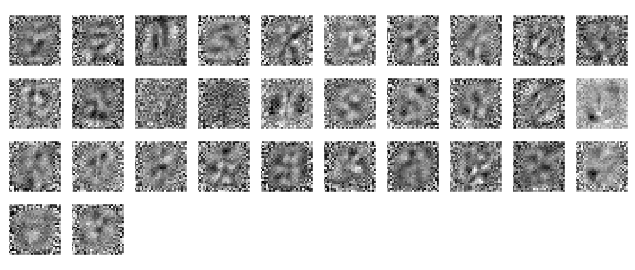

In [0]:
# веса слоя для 32х нейронного кодировщика

activation = models['32'].E.fc1.weight
to_plot = activation.view(-1,1,28,28).data.numpy()
plot_mnist(to_plot, (4, 10))

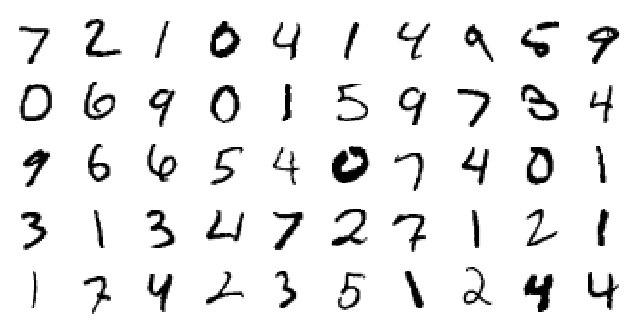

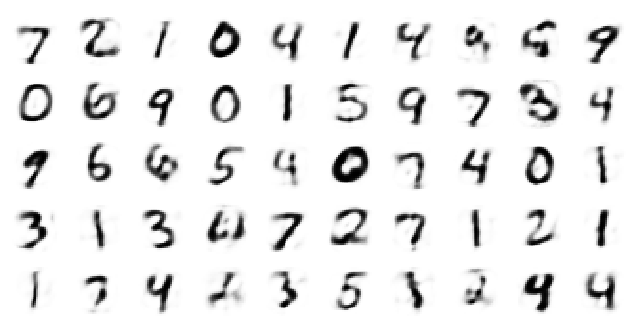

In [0]:
data, _ = next(iter(test_loader))
output = models['32'](data[:50])
to_plot = output.view(-1, 1, 28, 28).data.numpy()
plot_mnist(data.data.numpy()[:50], (5, 10))
plot_mnist(to_plot, (5, 10))

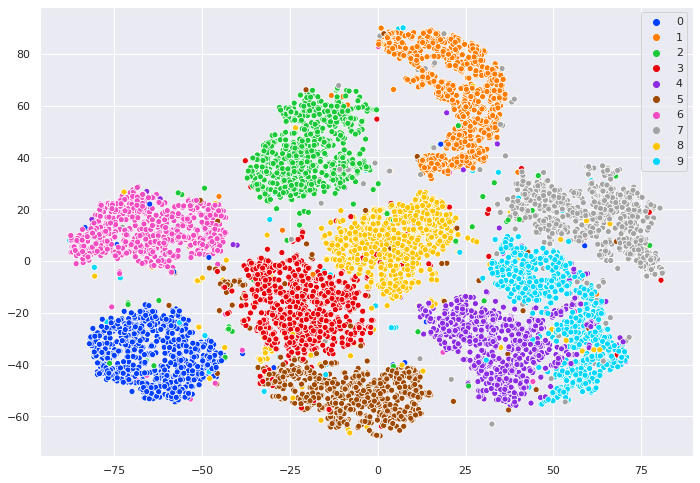

In [0]:
# t-SNE для латентного представления 32х нейронного кодировщика
from sklearn.manifold import TSNE
import seaborn as sns
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
           ])

data,labels = next(iter(DataLoader(dataset=datasets.MNIST(root='./MNIST_data', train=False, download=True, transform=mnist_transform), batch_size=10000, shuffle=True)))
data = models['32'].E(data.view(-1, 28*28))
data_embedded = TSNE(n_components=2).fit_transform(data.detach().numpy())
sns.scatterplot(data_embedded[:,0], data_embedded[:,1], hue=labels, legend='full', palette=palette)

In [0]:
def add_noise(x, mode='gaussian', elementwise=False):
    if np.random.randint(2):
        return x
    else:
      x = x.clone()
      if elementwise:
          if mode == 'crop':
              for i in range(x.shape[0]):
                  img_part = np.random.randint(5)
                  zero_one = np.random.randint(2)*2 - 1
                  if img_part == 0:
                      x[i, :, :14, :14] = zero_one
                  elif img_part == 1:
                      x[i, :, :14, 14:] = zero_one
                  elif img_part == 2:
                      x[i, :, 14:, :14] = zero_one
                  elif img_part == 3:
                      x[i, :, 14:, 14:] = zero_one
                  elif img_part == 4:
                      x[i, :, 7:21, 7:21] = zero_one
          elif mode == 'mirror':
              dim = x[0][0].shape[0]
              for i in range(x.shape[0]):
                  coords = [[0, int(dim/2)],
                            [int(dim/2),dim]]
                  p = {label: [coord[0], coord[1]] for label,coord in enumerate(itertools.product(coords,coords))}
                  l, a = np.random.randint(4), np.random.randint(1,3)
                  x[i, :, p[l][0][0]:p[l][0][1], p[l][1][0]:p[l][1][1]]=x[i, :, p[l][0][0]:p[l][0][1], p[l][1][0]:p[l][1][1]].flip(a)       
          
          elif mode == 'gaussian':
              size = x[0][0].size()
              std_rand = 1.5
              mean_rand = 0
              std = 0.5
              mean = 0.5
              for i in range(x.shape[0]):
                  x[i, :,] += x[i, :, ] + torch.randn(size) * std_rand + mean_rand
                  x[i, :,] = (x[i, :,] - x[i, :,].mean())/(x[i, :,].std()/std) + mean 
      else:
          if mode == 'crop':
              img_part = np.random.randint(5)
              zero_one = np.random.randint(2)*2 - 1
              if img_part == 0:
                  x[:, :, :14, :14] = zero_one
              elif img_part == 1:
                  x[:, :, :14, 14:] = zero_one
              elif img_part == 2:
                  x[:, :, 14:, :14] = zero_one
              elif img_part == 3:
                  x[:, :, 14:, 14:] = zero_one
              elif img_part == 4:
                  x[:, :, 7:21, 7:21] = zero_one
          if mode == 'mirror':
              dim = x[0][0].shape[0]
              coords = [[0, int(dim/2)],
                        [int(dim/2),dim]]

              #агрегатор для различных сочетаний, чтобы сделать какую-либо часть картинки отзеркаленной
              p = {label: [coord[0], coord[1]] for label,coord in enumerate(itertools.product(coords,coords))}
              # for item in p:
              #     print(item, p[item])
              # l - часть кaртинки, а - ось по которой отражаем
              l, a = np.random.randint(4), np.random.randint(2,4)
              # print(l, a)
              x[:, :, p[l][0][0]:p[l][0][1], p[l][1][0]:p[l][1][1]]=x[:, :, p[l][0][0]:p[l][0][1], p[l][1][0]:p[l][1][1]].flip(a)       
          if mode == 'gaussian':
              size = x[0][0].size()
              std_rand = 1.5
              mean_rand = 0
              std = 0.5
              mean = 0.5
              x[:, :] += x[:, :] + torch.randn(size) * std_rand + mean_rand
              x[:, :,] = (x[:, :,] - x[:, :,].mean())/(x[:, :,].std()/std)+mean            
      return x

def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        noized = add_noise(data, mode='gaussian')
        for model in models.values():
            model.optim.zero_grad()
            output = model(noized)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 150 == 0:
            line = 'Train Epoch: {} [{:05d}/{}] '.format(
                epoch, batch_idx * len(data), train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{:05d}/{}] '.format(
            epoch, batch_idx * len(data), train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append(models[k]._loss)
        print(line + losses)

avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
line = lambda i, l: '{}: '.format(i) + avg_lambda(l)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            noized = add_noise(data, mode='gaussian')
            output = {k: m(noized) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append(test_loss[k])
    
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [0]:
de_models = {'64': Net(latent_size=64)}
train_log = {k: [] for k in de_models}
test_log = {k: [] for k in de_models}

for epoch in range(1, 100):
    for model in de_models.values():
        model.train()
    train(epoch, de_models, log=train_log)
    for model in de_models.values():
        model.eval()
    test(de_models, test_loader, log=test_log )

Train Epoch: 1 [00000/60000] 64: 0.942093
Train Epoch: 1 [30000/60000] 64: 0.626787
Train Epoch: 1 [60000/60000] 64: 0.340472
Test set:
64: loss: 0.3448

Train Epoch: 2 [00000/60000] 64: 0.336567
Train Epoch: 2 [30000/60000] 64: 0.296120
Train Epoch: 2 [60000/60000] 64: 0.281517
Test set:
64: loss: 0.2838

Train Epoch: 3 [00000/60000] 64: 0.273424
Train Epoch: 3 [30000/60000] 64: 0.279213
Train Epoch: 3 [60000/60000] 64: 0.274351
Test set:
64: loss: 0.2758

Train Epoch: 4 [00000/60000] 64: 0.265922
Train Epoch: 4 [30000/60000] 64: 0.275227
Train Epoch: 4 [60000/60000] 64: 0.272052
Test set:
64: loss: 0.2733

Train Epoch: 5 [00000/60000] 64: 0.263350
Train Epoch: 5 [30000/60000] 64: 0.273493
Train Epoch: 5 [60000/60000] 64: 0.270871
Test set:
64: loss: 0.2720

Train Epoch: 6 [00000/60000] 64: 0.261984
Train Epoch: 6 [30000/60000] 64: 0.272651
Train Epoch: 6 [60000/60000] 64: 0.270262
Test set:
64: loss: 0.2714

Train Epoch: 7 [00000/60000] 64: 0.261448
Train Epoch: 7 [30000/60000] 64: 0

In [0]:
data, _ = next(iter(test_loader))
noized = add_noise(data, mode='gaussian', elementwise=True)
output = de_models['64'](noized[:50])
to_plot = output.view(-1, 1, 28, 28).data.numpy()

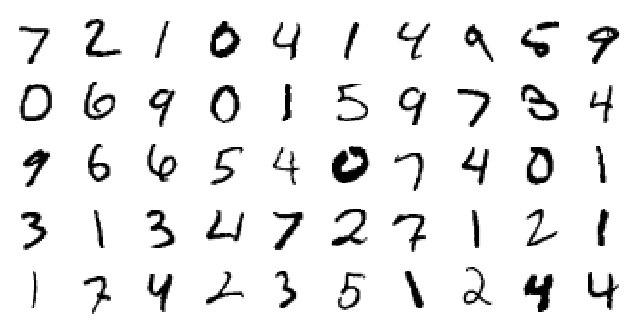

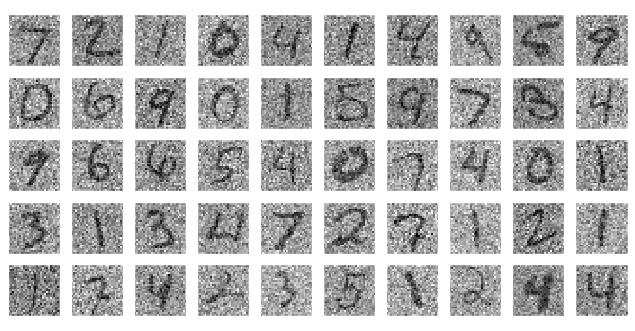

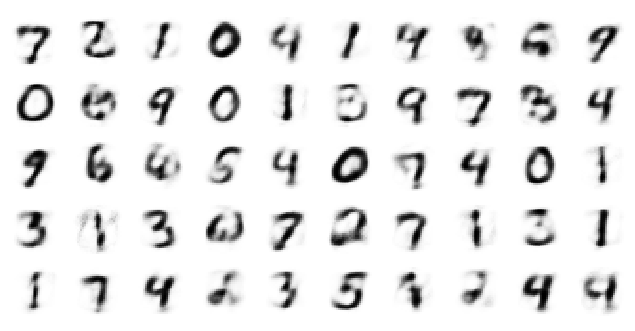

In [0]:
plot_mnist(data.data.numpy()[:50], (5, 10))
plot_mnist(noized[:50], (5, 10))
plot_mnist(to_plot, (5, 10))

In [0]:
class Encoder_cvl(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,16,3)
        self.conv2 = nn.Conv2d(16,32,3)
        self.pool = nn.MaxPool2d(2,2)
                
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        return x    

class Decoder_ml(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(12*12*32, 28*28)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x    



In [0]:
class Netcvl(nn.Module):
    def __init__(self, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super().__init__()
        self.E = Encoder_cvl()
        self.D = Decoder_ml()
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        h = self.E(x)
        h = h.view(-1,12*12*32)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [13]:
models = {'Cvl': Netcvl()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

for epoch in range(1, 10):
    for model in models.values():
        model.train()
    train(epoch, models, log=train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, log=test_log )

Train Epoch: 1 [00000/60000] Cvl: 0.938580
Train Epoch: 1 [30000/60000] Cvl: 0.202903
Train Epoch: 1 [60000/60000] Cvl: 0.125446
Test set:
Cvl: loss: 0.1055

Train Epoch: 2 [00000/60000] Cvl: 0.085574
Train Epoch: 2 [30000/60000] Cvl: 0.099779
Train Epoch: 2 [60000/60000] Cvl: 0.046855
Test set:
Cvl: loss: 0.0625

Train Epoch: 3 [00000/60000] Cvl: 0.046071
Train Epoch: 3 [30000/60000] Cvl: 0.065436
Train Epoch: 3 [60000/60000] Cvl: 0.061095
Test set:
Cvl: loss: 0.0506

Train Epoch: 4 [00000/60000] Cvl: 0.067131
Train Epoch: 4 [30000/60000] Cvl: 0.056903
Train Epoch: 4 [60000/60000] Cvl: 0.056902
Test set:
Cvl: loss: 0.0429

Train Epoch: 5 [00000/60000] Cvl: 0.027874
Train Epoch: 5 [30000/60000] Cvl: 0.027183
Train Epoch: 5 [60000/60000] Cvl: 0.050716
Test set:
Cvl: loss: 0.0387

Train Epoch: 6 [00000/60000] Cvl: 0.023589
Train Epoch: 6 [30000/60000] Cvl: 0.025824
Train Epoch: 6 [60000/60000] Cvl: 0.022367
Test set:
Cvl: loss: 0.0390

Train Epoch: 7 [00000/60000] Cvl: 0.060277
Train Epo

In [0]:
data, _ = next(iter(test_loader))
noized = add_noise(data, mode='gaussian', elementwise=True)
output = models['Cvl'](noized[:50])
to_plot = output.view(-1, 1, 28, 28).data.numpy()

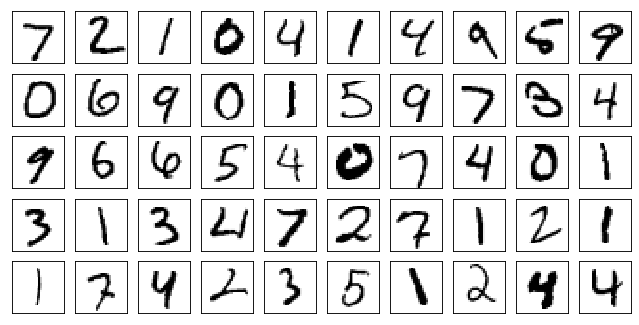

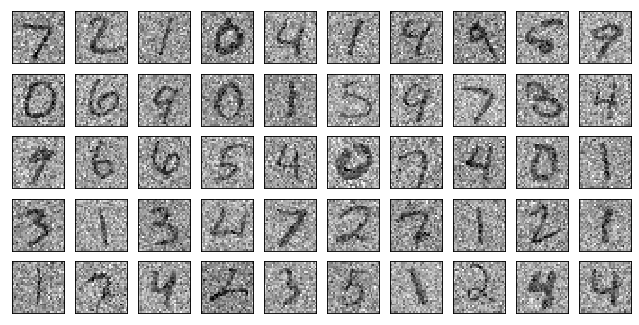

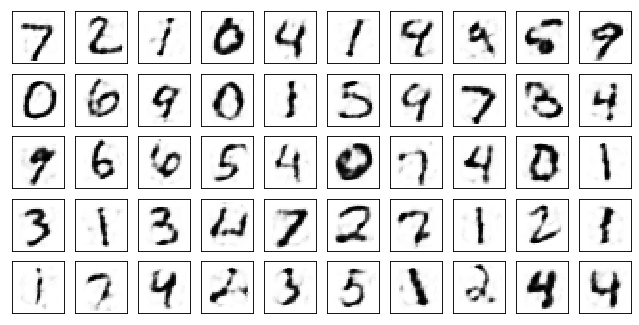

In [16]:
plot_mnist(data.data.numpy()[:50], (5, 10))
plot_mnist(noized[:50], (5, 10))
plot_mnist(to_plot, (5, 10))